In [1]:
%matplotlib inline

import gym
import math
import itertools
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import random
import numpy as np
import sys
from collections import deque

matplotlib.style.use('ggplot')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_config
from keras import backend as K

print(tf.__version__)
print(tf.keras.__version__)

2.0.0-beta1
2.2.4-tf


Using TensorFlow backend.


In [3]:
from gym import spaces
class MountainCarWrapper:
    def __init__(self, env): 
        self._action_space = spaces.Discrete(2)
        self._env = env
        
    @property
    def observation_space(self):
        return self._env.observation_space
        
    @property
    def action_space(self):
        return self._action_space
        
    def reset(self):
        return self._env.reset()
    
    def step(self, action):
        if (action == 1):
            action = 2
        return self._env.step(action)
    
    def render(self):
        return self._env.render()

In [4]:
class Memory:   # stored as ( s, a, r, s_, d )
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, sample):
        self.memory.append(sample)        

    def sample(self, n):
        n = min(n, len(self.memory))
        return random.sample(self.memory, n)

    def isFull(self):
        return len(self.memory) >= self.memory.maxlen
    
    def update(self, idx, p):
        pass


class SumTree:
    def __init__(self, capacity):
        self.write = 0
        self.capacity = capacity
        self.tree = np.zeros( 2*capacity - 1 )
        self.data = np.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    
class PERMemory:   # stored as ( s, a, r, s_, d ) in SumTree
    def __init__(self, capacity, alpha, epsilon=0.01):
        self.tree = SumTree(capacity)
        self.alpha = alpha
        self.epsilon = epsilon

    def _getPriority(self, error):
        return (error + self.epsilon) ** self.alpha

    def add(self, sample, error):
        p = self._getPriority(error)
        self.tree.add(p, sample) 

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [5]:
class DQNAgent:
    def __init__(self, 
                 observation_size, 
                 action_size, 
                 gamma = 1.0, 
                 epsilon = 0.1, 
                 epsilon_decay = None, 
                 memory_capacity = 25000):
        self.observation_size = observation_size
        self.action_size = action_size
        self.hidden_units = 64
        self.batch_size = 32
        
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.epsilon_decay = epsilon_decay
        if (epsilon_decay != None):
            self.epsilon = epsilon_decay[1]
        
        self.learning_rate = 0.005
        
        self.memory = Memory(memory_capacity)#PERMemory(memory_capacity, 0.2)
        
        self.steps = 0
        self.update_after = 1
            
        self.model, self.value_model = self._build_model()
        self.model_target = self._clone_model(self.model)
        
        self.update_target_model()
        
    def _build_model(self):
        inputs = keras.Input(shape = (self.observation_size,))
        
        # Shared layers
        x = layers.Dense(self.hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')(inputs)
     
        x = layers.Dense(self.hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')(x)

        # Learn advantage
        adv = layers.Dense(self.hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')(x)
        adv = layers.Dense(self.action_size, 
                         activation='linear', 
                         kernel_initializer='he_uniform')(adv)
        adv = layers.Lambda(lambda a: a - K.mean(a, axis=1, keepdims=True), output_shape=(action_size,))(adv)
        
        # Learn value
        value = layers.Dense(self.hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')(x)
        value = layers.Dense(1, 
                         activation='linear', 
                         kernel_initializer='he_uniform',
                         name="value_out")(value)
        
        # Combine into Q
        q_out = layers.Add()([adv, value])
        
        model = keras.Model(inputs=inputs, outputs=q_out)

        model.compile(optimizer=tf.keras.optimizers.Adam(self.learning_rate),
                      loss='mse')
        
        value_layer_model = keras.Model(inputs=model.input,
                                        outputs=model.get_layer("value_out").output)
        return model, value_layer_model
    
    def _clone_model(self, model):
        config = {
            'class_name': model.__class__.__name__,
            'config': model.get_config(),
        }
        clone = model_from_config(config)
        clone.set_weights(model.get_weights())
        return clone       
        
    def _act_egreedy(self, best_action):
        action_probs = np.ones(self.action_size, dtype=float) * self.epsilon / self.action_size
        action_probs[best_action] += (1.0 - self.epsilon)
        return np.random.choice(np.arange(len(action_probs)), p=action_probs)

    def remember(self, sample):
        self.memory.add(sample)            
        
    def act(self, observation, train=True):
        observation = np.reshape(observation, [1, self.observation_size]) 
        q_values = self.model.predict(observation)[0]
        action = np.argmax(q_values)
        
        if (train==True):
            # if we are training.  choose e-greedy.
            action = self._act_egreedy(action)
        
        return action
    
    def _get_targets(self, batch):
        no_state = np.zeros(self.observation_size)

        #observations = np.array([ x[1][0] for x in batch ])
        #next_observations = np.array([ (no_state if x[1][4] is True else x[1][3]) for x in batch ])
        observations = np.array([ x[0] for x in batch ])
        next_observations = np.array([ (no_state if x[4] is True else x[3]) for x in batch ])

        p = self.model.predict(observations)
        p_ = self.model.predict(next_observations)
        pTarget_ = self.model_target.predict(next_observations)
        
        targets = p
        
        errors = np.zeros(len(batch))
        
        for index, batch_entry in enumerate(batch):
            sample = batch_entry#[1]
            action = sample[1]
            reward = sample[2]
            done = sample[4]
            
            old_target = targets[index][action]
            
            if (done == True):
                targets[index][action] = reward
            else:
                targets[index][action] = reward + self.gamma * pTarget_[index][ np.argmax(p_[index]) ]  # double DQN
        
            errors[index] = abs(old_target - targets[index][action])

        return observations, targets, errors
        
    def replay(self):
        batch = self.memory.sample(self.batch_size)
        observations, targets, errors = self._get_targets(batch)

        #update errors
        #for i in range(len(batch)):
        #    idx = batch[i][0]
        #    self.memory.update(idx, errors[i])

        self.model.fit(observations, targets, epochs=1, verbose=0)
        
        self.steps += 1
        
        if (self.steps % self.update_after == 0):
            self.update_target_model()
        
        if (self.epsilon_decay != None):
            # decay epsilon with provided params.
            min_epsilon = self.epsilon_decay[0]
            max_epsilon = self.epsilon_decay[1]
            decay_rate = self.epsilon_decay[2]
            
            self.epsilon = min_epsilon + (max_epsilon - min_epsilon) * math.exp(-decay_rate * self.steps)

    def update_target_model(self):
        self.model_target.set_weights(self.model.get_weights())        
                

def train_agent (env, agent, num_episodes, train_until):
      
    rewards = []
    epsilons = []
        
    for episodeIx in range(num_episodes):
        # reset state in the beginning of each game
        done = False
        observation = env.reset()
        episode_rewards = 0
        while not done:
            action = agent.act(observation)
            next_observation, reward, done, _ = env.step(action)
            agent.remember((observation, action, reward, next_observation, done))
            observation = next_observation
            episode_rewards += reward
            
            # train the agent with the experience of the episode
            agent.replay()
            
        rewards.append(episode_rewards)
        epsilons.append(agent.epsilon)
        
        rewards_mean = np.mean(rewards[-min(10, len(rewards)):])
        
        print("\repisode: {}/{}.\trewards={}.\tepsilon={}\tMean={}.".format(episodeIx+1, 
                                                                            num_episodes,
                                                                            episode_rewards,
                                                                            round(agent.epsilon, 4),
                                                                            round(rewards_mean, 2)), end="")
            
        if  rewards_mean > train_until:
            break
            
    return rewards, epsilons
            
def run_episode(env, agent, render=True):
    rewards = 0
    done = False
    observation = env.reset()

    while not done:
        if (render is True):
            env.render()
        action = agent.act(observation, train=False)
        observation, reward, done, _ = env.step(action)
        rewards += reward
        
    return rewards

In [6]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

observation_size = env.observation_space.shape[0]
action_size = env.action_space.n

gamma = 1.0
memory_capacity = 25000
epsilon_decay = None

train_until = 490

if (env_name == 'MountainCar-v0'):
    env = MountainCarWrapper(env)
    
    observation_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    gamma = 0.99
    epsilon_decay = [0.1, 1.0, 0.0001]
    memory_capacity = 100000
    
    train_until = -150


agent = DQNAgent(observation_size, 
                 action_size, 
                 gamma=gamma, 
                 epsilon_decay=epsilon_decay, 
                 memory_capacity=memory_capacity)

In [7]:
rewards, epsilons = train_agent(env, agent, 500, train_until)

episode: 89/500.	rewards=500.0.	epsilon=0.1	Mean=500.0.

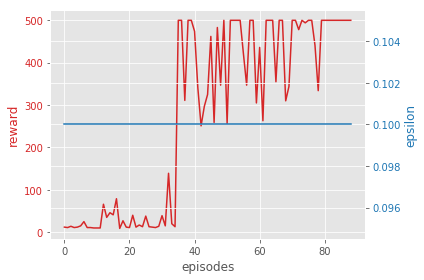

In [8]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('episodes')
ax1.set_ylabel('reward', color=color)
ax1.plot(rewards, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(epsilons, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
#agent.model.load_weights("{}_dqn.h5".format(env_name))
#agent.model.save_weights("{}_dqn.h5".format(env_name))

In [18]:
run_episode(env, agent)

500.0

In [11]:
if (env_name == 'MountainCar-v0'):
    values = np.zeros((100, 100))

    for position in range (100):
        for velocity in range (100):
            observation = np.zeros((1,2))
            observation[0, 0] = -1.2 + position * 0.018
            observation[0, 1] = -0.07 + velocity * 0.0014

            values[position, velocity] = agent.value_model(observation)
    
    # plot value function.
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')

    x = range(0, 100)
    y = range(0, 100)

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ax.plot_surface(X.T, Y.T, values)

    plt.show()   

In [17]:
observation = env.reset()
observation = np.reshape(observation, [1, observation.shape[0]]) 
value = agent.value_model(observation)
print(value)

tf.Tensor([[7.833082e+08]], shape=(1, 1), dtype=float32)
